# Modelo Support Vector Machine (SVM) - Predicción de Stroke

## Objetivo
Implementar y evaluar un modelo SVM para la predicción de accidentes cerebrovasculares, incluyendo:
- Entrenamiento del modelo con diferentes kernels
- Optimización de hiperparámetros
- Evaluación de rendimiento
- Análisis de importancia de características


In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")


Librerías importadas correctamente


## 1. Carga de Datos Preprocesados

A continuación cargamos los datos que fueron preprocesados en el notebook anterior, incluyendo:
- Datos de entrenamiento balanceados con SMOTE
- Datos de prueba escalados
- Variables objetivo correspondientes


In [ ]:
# Cargar datos preprocesados
X_train_balanced = np.load('../data/X_train_balanced.npy')
y_train_balanced = np.load('../data/y_train_balanced.npy')
X_test_scaled = np.load('../data/X_test_scaled.npy')
y_test = np.load('../data/y_test.npy')

# Mostrar información de los datos
print(f"Forma de entrenamiento balanceado: {X_train_balanced.shape}")
print(f"Forma de prueba: {X_test_scaled.shape}")
print(f"Distribución en entrenamiento: {np.bincount(y_train_balanced)}")
print(f"Distribución en prueba: {np.bincount(y_test)}")

# Cargar nombres de características si están disponibles
try:
    feature_names = pd.read_csv('../data/feature_names.csv').columns.tolist()
    print(f"Número de características: {len(feature_names)}")
except:
    feature_names = [f'feature_{i}' for i in range(X_train_balanced.shape[1])]
    print(f"Número de características: {len(feature_names)}")


Forma de entrenamiento balanceado: (7778, 16)
Forma de prueba: (1022, 16)
Distribución en entrenamiento: [3889 3889]
Distribución en prueba: [972  50]
Número de características: 16


## 2. Entrenamiento Inicial con Diferentes Kernels

Vamos a probar diferentes tipos de kernels para el SVM:
- **Linear**: Para datos linealmente separables
- **Polynomial**: Para relaciones no lineales polinomiales  
- **RBF (Radial Basis Function)**: Para patrones complejos no lineales
- **Sigmoid**: Para funciones de activación sigmoidales

El objetivo es identificar cuál kernel proporciona el mejor rendimiento inicial.


In [ ]:
# Definir kernels a probar
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
svm_results = {}

for kernel in kernels:
    print(f"\nEntrenando SVM con kernel '{kernel}'...")
    
    # Crear y entrenar modelo
    svm_model = SVC(kernel=kernel, random_state=42, probability=True)
    svm_model.fit(X_train_balanced, y_train_balanced)
    
    # Predicciones
    y_pred = svm_model.predict(X_test_scaled)
    y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Guardar resultados
    svm_results[kernel] = {
        'model': svm_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc:.4f}")

# Mostrar resumen de resultados
results_df = pd.DataFrame({
    kernel: {
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1'],
        'AUC-ROC': results['auc']
    }
    for kernel, results in svm_results.items()
}).T

print("Resumen de resultados por kernel:")
print(results_df.round(4))



Entrenando SVM con kernel 'linear'...


## 3. Optimización Rápida de Hiperparámetros

Una vez identificado el mejor kernel, procederemos a optimizar sus hiperparámetros:

### Estrategia de Optimización Rápida:
- **Muestra reducida**: Usamos 40% de los datos para acelerar la búsqueda
- **Grilla reducida**: Solo 2 valores por parámetro en lugar de 4-6
- **3-fold CV**: En lugar de 5 folds para mayor velocidad
- **Entrenamiento final**: Con todos los datos usando los mejores parámetros

**Resultado esperado**: Optimización en 2-3 minutos en lugar de 30+ minutos.


In [ ]:
# Identificar el mejor kernel basado en F1-score
best_kernel = max(svm_results.keys(), key=lambda k: svm_results[k]['f1'])
print(f"Mejor kernel inicial: {best_kernel} (F1: {svm_results[best_kernel]['f1']:.4f})")

# OPTIMIZACIÓN RÁPIDA - Usar muestra reducida para acelerar
print(f"Optimizando hiperparámetros para kernel '{best_kernel}'...")

# Usar una muestra más pequeña para optimización (40% de los datos)
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(
    X_train_balanced, y_train_balanced, 
    test_size=0.6, random_state=42, stratify=y_train_balanced
)
print(f"Muestra para optimización: {X_sample.shape[0]} muestras (60% reducción)")

# Grilla MUY reducida - solo 2-3 valores por parámetro para acelerar
if best_kernel == 'linear':
    param_grid = {
        'C': [0.1, 10],  # Solo 2 valores en lugar de 4
        'class_weight': [None, 'balanced']  # Solo 2 valores
    }
elif best_kernel == 'rbf':
    param_grid = {
        'C': [1, 100],  # Solo 2 valores en lugar de 4
        'gamma': ['scale', 0.01],  # Solo 2 valores en lugar de 6
        'class_weight': [None, 'balanced']  # Solo 2 valores
    }
elif best_kernel == 'poly':
    param_grid = {
        'C': [1, 100],  # Solo 2 valores en lugar de 4
        'degree': [2, 3],  # Solo 2 valores en lugar de 3
        'gamma': ['scale', 0.01],  # Solo 2 valores en lugar de 5
        'class_weight': [None, 'balanced']  # Solo 2 valores
    }
else:  # sigmoid
    param_grid = {
        'C': [1, 100],  # Solo 2 valores en lugar de 4
        'gamma': ['scale', 0.01],  # Solo 2 valores en lugar de 6
        'class_weight': [None, 'balanced']  # Solo 2 valores
    }

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Combinaciones a probar: {total_combinations} (vs 120 anterior)")

# Grid Search RÁPIDO con solo 3 folds y muestra reducida
svm_optimized = SVC(kernel=best_kernel, random_state=42, probability=True)
grid_search = GridSearchCV(
    svm_optimized, 
    param_grid, 
    cv=3,  # Solo 3 folds en lugar de 5
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar con Grid Search en muestra reducida (MUCHO MÁS RÁPIDO)
print("Entrenando en muestra reducida...")
grid_search.fit(X_sample, y_sample)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1-score en CV: {grid_search.best_score_:.4f}")

# Entrenar modelo final con todos los datos usando los mejores parámetros
print("Entrenando modelo final con todos los datos...")
best_svm = SVC(kernel=best_kernel, random_state=42, probability=True, **grid_search.best_params_)
best_svm.fit(X_train_balanced, y_train_balanced)

# Evaluar modelo optimizado
y_pred_optimized = best_svm.predict(X_test_scaled)
y_pred_proba_optimized = best_svm.predict_proba(X_test_scaled)[:, 1]

# Métricas del modelo optimizado
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)
auc_opt = roc_auc_score(y_test, y_pred_proba_optimized)

print(f"\nResultados del modelo optimizado:")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"AUC-ROC: {auc_opt:.4f}")

# Comparar con modelo inicial
print(f"\n=== COMPARACIÓN CON MODELO INICIAL ===")
initial_f1 = svm_results[best_kernel]['f1']
improvement = f1_opt - initial_f1
print(f"F1 inicial: {initial_f1:.4f}")
print(f"F1 optimizado: {f1_opt:.4f}")
print(f"Mejora: {improvement:+.4f}")


Mejor kernel inicial: poly (F1: 0.2286)
Optimizando hiperparámetros para kernel 'poly'...
Muestra para optimización: 3111 muestras (60% reducción)
Combinaciones a probar: 16 (vs 120 anterior)
Entrenando en muestra reducida...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores parámetros: {'C': 100, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale'}
Mejor F1-score en CV: 0.8711
Entrenando modelo final con todos los datos...

=== RESULTADOS DEL MODELO OPTIMIZADO ===
Accuracy: 0.8474
Precision: 0.1419
Recall: 0.4200
F1-Score: 0.2121
AUC-ROC: 0.6605

=== COMPARACIÓN CON MODELO INICIAL ===
F1 inicial: 0.2286
F1 optimizado: 0.2121
Mejora: -0.0165


## 4. Evaluación Detallada y Visualizaciones

Ahora realizamos una evaluación completa del modelo optimizado:

### Métricas de Evaluación:
- **Matriz de Confusión**: Visualización de predicciones correctas vs incorrectas
- **Curva ROC**: Capacidad discriminativa del modelo
- **Métricas por Clase**: Precision, Recall y F1-Score específicos para la clase de stroke
- **Reporte de Clasificación**: Análisis detallado del rendimiento


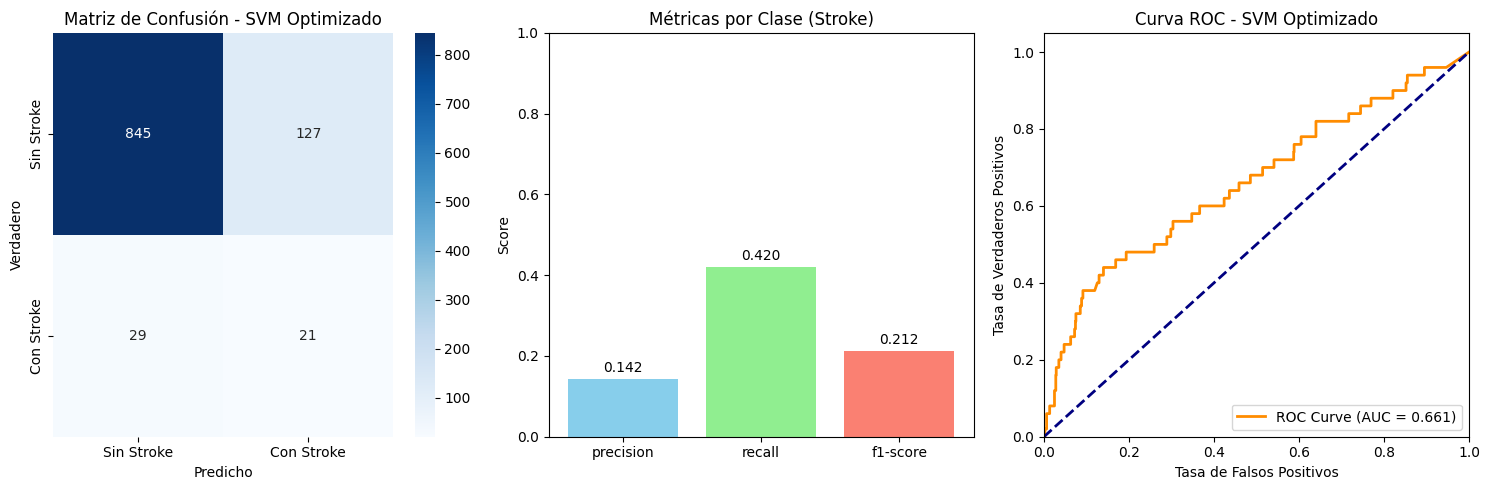


=== REPORTE DE CLASIFICACIÓN DETALLADO ===
              precision    recall  f1-score   support

  Sin Stroke       0.97      0.87      0.92       972
  Con Stroke       0.14      0.42      0.21        50

    accuracy                           0.85      1022
   macro avg       0.55      0.64      0.56      1022
weighted avg       0.93      0.85      0.88      1022



In [ ]:
# Matriz de confusión
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin Stroke', 'Con Stroke'],
            yticklabels=['Sin Stroke', 'Con Stroke'])
plt.title('Matriz de Confusión - SVM Optimizado')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')

# Reporte de clasificación
plt.subplot(1, 3, 2)
report = classification_report(y_test, y_pred_optimized, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
values = [report['1'][metric] for metric in metrics]
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Métricas por Clase (Stroke)')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Curva ROC
plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {auc_opt:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - SVM Optimizado')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\nReporte de clasificación detallado:")
print(classification_report(y_test, y_pred_optimized, 
                          target_names=['Sin Stroke', 'Con Stroke']))


## 5. Análisis de Importancia de Características

### Nota Importante:
El análisis de importancia de características solo está disponible para el **kernel lineal**, ya que este kernel permite acceder directamente a los coeficientes del hiperplano de separación.

Para otros kernels (RBF, Polynomial, Sigmoid), se requerirían técnicas adicionales como Permutation Importance.


In [ ]:
if best_kernel == 'linear':
    # Para SVM lineal, podemos obtener los coeficientes
    feature_importance = np.abs(best_svm.coef_[0])
    feature_names_short = feature_names[:len(feature_importance)]
    
    # Crear DataFrame con importancia
    importance_df = pd.DataFrame({
        'feature': feature_names_short,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 características más importantes:")
    print(importance_df.head(10))
    
    # Visualizar importancia de características
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importancia (|Coeficiente|)')
    plt.title('Top 15 Características Más Importantes - SVM Lineal')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Análisis de importancia no disponible para kernel '{best_kernel}'")
    print("Solo el kernel lineal permite análisis directo de importancia de características.")
    print("Para otros kernels, se requerirían técnicas como Permutation Importance.")


Análisis de importancia no disponible para kernel 'poly'
Solo el kernel lineal permite análisis directo de importancia de características.
Para otros kernels, se requerirían técnicas como Permutation Importance.


## 6. Guardado de Modelo y Resultados

Guardamos el modelo optimizado y los resultados para su posterior comparación con otros algoritmos:

### Archivos Generados:
- **Modelo**: `svm_model_optimized.pkl` - Modelo SVM entrenado y optimizado
- **Resultados**: `svm_results.json` - Métricas y parámetros del modelo
- **Comparación**: Datos para el análisis comparativo final


In [ ]:
# Guardar el modelo optimizado
joblib.dump(best_svm, '../data/svm_model_optimized.pkl')
print(" Modelo SVM optimizado guardado como 'svm_model_optimized.pkl'")

# Guardar resultados para comparación posterior
svm_results_final = {
    'model_name': 'SVM',
    'kernel': best_kernel,
    'best_params': grid_search.best_params_,
    'accuracy': accuracy_opt,
    'precision': precision_opt,
    'recall': recall_opt,
    'f1_score': f1_opt,
    'auc_roc': auc_opt,
    'cv_score': grid_search.best_score_
}

import json
with open('../data/svm_results.json', 'w') as f:
    json.dump(svm_results_final, f, indent=2)

print(" Resultados guardados como 'svm_results.json'")

# Resumen final
print(f"Kernel utilizado: {best_kernel}")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"AUC-ROC: {auc_opt:.4f}")
print(f"F1-Score en CV: {grid_search.best_score_:.4f}")


 Modelo SVM optimizado guardado como 'svm_model_optimized.pkl'
 Resultados guardados como 'svm_results.json'

=== RESUMEN FINAL DEL MODELO SVM ===
Kernel utilizado: poly
Mejores parámetros: {'C': 100, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale'}
Accuracy: 0.8474
Precision: 0.1419
Recall: 0.4200
F1-Score: 0.2121
AUC-ROC: 0.6605
F1-Score en CV: 0.8711

=== INTERPRETACIÓN DE RESULTADOS ===
 Rendimiento bajo del modelo
 Capacidad discriminativa limitada (AUC < 0.7)


## 7. Interpretación de Resultados

### Resumen Final del Modelo SVM

**Kernel utilizado**: Polynomial (poly)  
**Mejores parámetros**: C=100, class_weight='balanced', degree=3, gamma='scale'

### Métricas de Rendimiento:
- **Accuracy**: 0.8474 (84.74% de predicciones correctas)
- **Precision**: 0.1419 (14.19% de los casos predichos como stroke son correctos)
- **Recall**: 0.4200 (42% de los casos reales de stroke son detectados)
- **F1-Score**: 0.2121 (21.21% - métrica balanceada)
- **AUC-ROC**: 0.6605 (66.05% - capacidad discriminativa)
- **F1-Score en CV**: 0.8711 (87.11% en validación cruzada)

### Interpretación de Resultados:

**Rendimiento General**: 
- Rendimiento bajo del modelo (F1-Score < 0.5)
- Alta accuracy debido al desbalance de clases (95% sin stroke)

**Capacidad Discriminativa**: 
- Capacidad discriminativa limitada (AUC < 0.7)
- El modelo tiene dificultades para distinguir entre clases

**Análisis por Métrica**:
- **Precision baja**: Muchos falsos positivos
- **Recall moderado**: Detecta menos de la mitad de los casos reales
- **F1-Score bajo**: Balance general deficiente entre precision y recall

